## Import modules

In [1]:
import numpy as np
import open3d as o3d
from sklearn.ensemble import RandomForestClassifier
import pdal
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plyfile import PlyData, PlyElement
import gc
from itertools import chain
from sklearn.metrics import confusion_matrix
import os
import joblib # Use to save model
from datetime import datetime, timezone
# from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from glob import glob
# from sklearn.model_selection import GridSearchCV
sns.set()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# ROOT_PLY = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/L001.ply"""

## Load in features

In [3]:
ROOT = """/home/sspiegel/CapstoneData/Paris/training_10_classes/pickleFiles/radial/training/2025_11_10T17_46_Lille1_1_r_0_1_grid_0_02_features.npz"""
ROOT2 = """/home/sspiegel/CapstoneData/Paris/training_10_classes/pickleFiles/radial/training/2025_11_10T18_21_Lille1_1_r_0_2_grid_0_04_features.npz"""
ROOT3 = """/home/sspiegel/CapstoneData/Paris/training_10_classes/pickleFiles/radial/training/2025_11_10T18_49_Lille1_1_r_0_4_grid_0_08_features.npz"""
ROOT4 = """/home/sspiegel/CapstoneData/Paris/training_10_classes/pickleFiles/radial/training/2025_11_10T19_33_Lille1_1_r_0_8_grid_0_16_features.npz"""
ROOT5 = """/home/sspiegel/CapstoneData/Paris/training_10_classes/pickleFiles/radial/training/2025_11_10T20_00_Lille1_1_r_1_6_grid_0_32_features.npz"""
ROOT6 = """/home/sspiegel/CapstoneData/Paris/training_10_classes/pickleFiles/radial/training/2025_11_10T20_37_Lille1_1_r_3_2_grid_0_64_features.npz"""

In [4]:
fileList = [ROOT,ROOT2, ROOT3,ROOT4,ROOT5, ROOT6]

## Get computed features

In [5]:
das = [np.load(r)["array2"] for r in fileList]
das = np.hstack(das)

xyz = np.load(fileList[0])["array1"]

cls = np.load(fileList[0])["array3"]

## Load in points and labels

## Combine road markings with Ground points

In [6]:
# cls[cls==2] = 1

In [7]:
# cls[cls > 1] -= 1

## Get columns

In [8]:
cols = ["EigenSum","omnivariance","entropy","linearity","planarity","sphericity","curvature","verticality1","verticality2","count"]

In [9]:
# cols1 = [f"""{a}_radius1""" for a in cols]
# cols2 = [f"""{a}_radius2""" for a in cols]
ff = []

for i in range(1, len(fileList) + 1):
    col = [f"""{a}_radius{i}""" for a in cols]
    ff += col
    

# allCols = cols1 + cols2
    
    
    

In [10]:
allCols = ['X', 'Y','Z'] + ff + ['label']

In [11]:
allAtrs = np.hstack((xyz,das, cls.reshape(-1, 1)))

In [12]:
del xyz, das, cls

## Create dataframe

In [13]:
total_dataframe = pd.DataFrame(allAtrs, columns=allCols)
total_dataframe["label"] = total_dataframe["label"].astype(int)
for i in range(1, len(fileList) + 1):
    total_dataframe[f"""count_radius{i}"""] = total_dataframe[f"""count_radius{i}"""].astype(int)
# total_dataframe["count_radius1"] = total_dataframe["count_radius1"].astype(int)
# total_dataframe["count_radius2"] = total_dataframe["count_radius2"].astype(int)

# total_dataframe["labelName"] = total_dataframe["label"].apply(labelPoints)

In [14]:
gc.collect()

88

In [15]:
# ss = ss[ss["count"] > 10]

In [16]:
total_dataframe.head()

,X,Y,Z,EigenSum_radius1,omnivariance_radius1,entropy_radius1,linearity_radius1,planarity_radius1,sphericity_radius1,curvature_radius1,...,omnivariance_radius6,entropy_radius6,linearity_radius6,planarity_radius6,sphericity_radius6,curvature_radius6,verticality1_radius6,verticality2_radius6,count_radius6,label
0,398.298103,495.176231,22.109970,0.003787,0.000934,0.024369,0.528569,0.340711,0.130719,0.081590,...,1.012064,-1.866564,0.702790,0.089774,0.207436,0.137864,1.091669,0.190870,95,2
1,398.266228,495.191902,22.098022,0.004604,0.001048,0.028610,0.453144,0.451297,0.095559,0.058182,...,1.015076,-1.981443,0.710927,0.088566,0.200507,0.134606,1.092904,0.189383,96,2
2,398.299938,495.256958,22.048336,0.005533,0.001166,0.033090,0.547250,0.379239,0.073511,0.048164,...,1.034304,-1.713657,0.671517,0.101873,0.226610,0.145721,1.029475,0.304626,97,2
3,398.330696,495.314888,22.004002,0.004183,0.001085,0.026684,0.416855,0.425483,0.157662,0.090568,...,1.034784,-1.777518,0.678289,0.099996,0.221715,0.143651,1.029406,0.295259,98,2
4,398.616806,495.714172,22.145325,0.002058,0.000529,0.014515,0.606084,0.231901,0.162015,0.104127,...,1.007042,-1.248575,0.646685,0.085454,0.267861,0.165226,1.020719,0.285616,95,2


## Create PLY files with features (Only do if they don't already exist)

In [17]:
# for i in range(1, 7):
#     ls = [col for col in list(total_dataframe) if col.endswith(f"""radius{i}""")]
#     ls = ['X','Y','Z'] + ls + ['label']
#     partial_df = total_dataframe[ls]

#     tpsOut = []
#     for idx, tpe in partial_df.dtypes.to_dict().items():
#         if tpe == 'int64':
#             tpsOut.append((idx, 'i4'))
#         elif tpe == 'float64':
#             tpsOut.append((idx, 'f8'))
            
#     vertex_data = np.empty(allAtrs.shape[0], dtype=tpsOut)
    
#     for t in tpsOut:
#         vertex_data[t[0]] = partial_df[t[0]].values
    
        
#     el = PlyElement.describe(vertex_data, 'vertex')
    
#     # Create a PlyData object and write to a PLY file
#     # Set text=True for ASCII PLY, or text=False for binary PLY
#     PlyData([el], text=False).write(f"""/home/sspiegel/CapstoneData/Paris/Toronto_3D/PC_with_features/L002_features_radius{i}.ply""")

In [18]:
total_dataframe = total_dataframe.query("label != 0") # We are not going to train on unclassified points
total_dataframe = total_dataframe.copy()

## Load Random Forest classifier

In [19]:
gc.collect()

3

In [20]:
total_dataframe.groupby("label").size() / total_dataframe.shape[0]

label
1    0.585338
2    0.248784
3    0.005602
4    0.000259
5    0.002248
6    0.040576
7    0.000546
8    0.043279
9    0.073367
dtype: float64

In [21]:
rf = RandomForestClassifier(verbose=1, n_jobs=8)

In [22]:
total_dataframe.reset_index(inplace = True)

In [23]:
gc.collect()

0

In [24]:
maxAcc = 0.0

AccList = []

F1_ScoreList = []

AccDelta = 1e-4

difDelta = np.inf

# f1_score(y_true, y_pred, average='weighted')


randomState = 123
sampleSize = 2000

iters = 0


idsTrained = []

RemainTest = total_dataframe.copy()

while (difDelta >= AccDelta) and ( iters < 50):
    # print(sampleSize)
    print("""Starting iteration %d...""" % (iters + 1))
    TrainList = []
    idsList = []

    for i in range(1,10):
    #     if iters > 0: # Change sampling size after initial sample is given
    #         sampleSize = 1000
        print(f"""Label {i}""")
        SelectList = RemainTest.loc[RemainTest["label"] == i]
        SelectList = SelectList.copy()
        trns = SelectList.sample(n = sampleSize, random_state = randomState)
        idsList.append(trns.index.to_list())
        
        TrainList.append(trns)
    idsList = list(chain.from_iterable(idsList))
    idsTrained += idsList

    TrainList = total_dataframe.loc[idsTrained]

    # TrainList = pd.concat(TrainList)
    
    TrainList = TrainList.sample(frac = 1., random_state = randomState)
    
    TrainListX = TrainList[ff]
    TrainListY = TrainList["label"]
        
    rf.fit(TrainListX, TrainListY)
    
        
    RemainTestX = RemainTest[ff]
    RemainTestY = RemainTest["label"]
    
    RemainTest = RemainTest.loc[~RemainTest["index"].isin(idsTrained)]
    
    
    yPred = rf.predict(RemainTestX)
        
    RemainTestSample = RemainTest.sample(frac = 0.1, random_state=randomState)
    RemainTestSampleX = RemainTestSample[ff]
    RemainTestSampleY = RemainTestSample["label"]
    
    yPredSample = rf.predict(RemainTestSampleX)
    acc = (yPredSample==RemainTestSampleY).sum() / RemainTestSampleY.shape[0]

    print("""Current accuracy: %.4f""" % (100*acc))
    AccList.append(acc)
    f1 = f1_score(RemainTestSampleY, yPredSample,average = "weighted")

    difDelta = np.abs(maxAcc - f1)

    print("""\n\nCurrent f1 score: %.5f""" % f1)

    print("""\n\nCurrent f1 score delta: %.5f""" % difDelta)
    
    if acc > maxAcc:
        maxAcc = f1
    

    iters += 1

    # idsTrained += idsList  
    gc.collect()

print("""DONE!!!!""")   

    
    
    
    
    # print(total_dataframe.loc[total_dataframe["label"] == i].shape[0])

Starting iteration 1...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   24.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.8s finished


Current accuracy: 93.8608


Current f1 score: 0.94471


Current f1 score delta: 0.94471
Starting iteration 2...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   25.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    8.5s finished


Current accuracy: 94.8881


Current f1 score: 0.95299


Current f1 score delta: 0.00828
Starting iteration 3...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    8.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   22.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    8.8s finished


Current accuracy: 95.4229


Current f1 score: 0.95750


Current f1 score delta: 0.00451
Starting iteration 4...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   11.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   25.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    8.9s finished


Current accuracy: 95.7436


Current f1 score: 0.96021


Current f1 score delta: 0.00271
Starting iteration 5...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   14.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   25.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    9.4s finished


Current accuracy: 95.9767


Current f1 score: 0.96223


Current f1 score delta: 0.00473
Starting iteration 6...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    7.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   18.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   26.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    9.6s finished


Current accuracy: 96.2616


Current f1 score: 0.96473


Current f1 score delta: 0.00250
Starting iteration 7...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    8.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   22.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   24.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    9.2s finished


Current accuracy: 96.3967


Current f1 score: 0.96593


Current f1 score delta: 0.00120
Starting iteration 8...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    9.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   25.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   26.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    9.9s finished


Current accuracy: 96.5396


Current f1 score: 0.96718


Current f1 score delta: 0.00245
Starting iteration 9...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   10.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   28.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   24.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    9.9s finished


Current accuracy: 96.7017


Current f1 score: 0.96862


Current f1 score delta: 0.00145
Starting iteration 10...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   12.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   33.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   27.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    9.8s finished


Current accuracy: 96.7929


Current f1 score: 0.96943


Current f1 score delta: 0.00225
Starting iteration 11...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   13.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   37.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   26.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   10.0s finished


Current accuracy: 96.9588


Current f1 score: 0.97095


Current f1 score delta: 0.00152
Starting iteration 12...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   15.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   42.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   25.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    9.9s finished


Current accuracy: 97.0118


Current f1 score: 0.97138


Current f1 score delta: 0.00044
Starting iteration 13...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   16.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   44.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   28.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   10.5s finished


Current accuracy: 97.1138


Current f1 score: 0.97233


Current f1 score delta: 0.00138
Starting iteration 14...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   18.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   49.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   27.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   10.5s finished


Current accuracy: 97.2158


Current f1 score: 0.97322


Current f1 score delta: 0.00089
Starting iteration 15...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   19.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   52.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   28.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   10.5s finished


Current accuracy: 97.2727


Current f1 score: 0.97377


Current f1 score delta: 0.00144
Starting iteration 16...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   22.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   30.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   10.6s finished


Current accuracy: 97.3527


Current f1 score: 0.97448


Current f1 score delta: 0.00072
Starting iteration 17...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   22.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   28.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   10.6s finished


Current accuracy: 97.4124


Current f1 score: 0.97501


Current f1 score delta: 0.00124
Starting iteration 18...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   24.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   31.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   11.0s finished


Current accuracy: 97.4730


Current f1 score: 0.97559


Current f1 score delta: 0.00058
Starting iteration 19...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   27.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   29.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   11.0s finished


Current accuracy: 97.5380


Current f1 score: 0.97619


Current f1 score delta: 0.00118
Starting iteration 20...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   27.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   28.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   11.0s finished


Current accuracy: 97.5817


Current f1 score: 0.97657


Current f1 score delta: 0.00039
Starting iteration 21...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   29.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   34.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   10.4s finished


Current accuracy: 97.6437


Current f1 score: 0.97715


Current f1 score delta: 0.00096
Starting iteration 22...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   30.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   27.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   10.9s finished


Current accuracy: 97.6866


Current f1 score: 0.97756


Current f1 score delta: 0.00041
Starting iteration 23...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   33.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   30.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   11.0s finished


Current accuracy: 97.7323


Current f1 score: 0.97800


Current f1 score delta: 0.00085
Starting iteration 24...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   36.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   31.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   11.9s finished


Current accuracy: 97.7430


Current f1 score: 0.97808


Current f1 score delta: 0.00008
DONE!!!!


In [29]:
gc.collect()

0

## Plot iterations and accuracy

In [30]:
# plot_df = pd.DataFrame(data = {"F1 Score" : F1_ScoreList, "Overall Accuracy" : AccList})

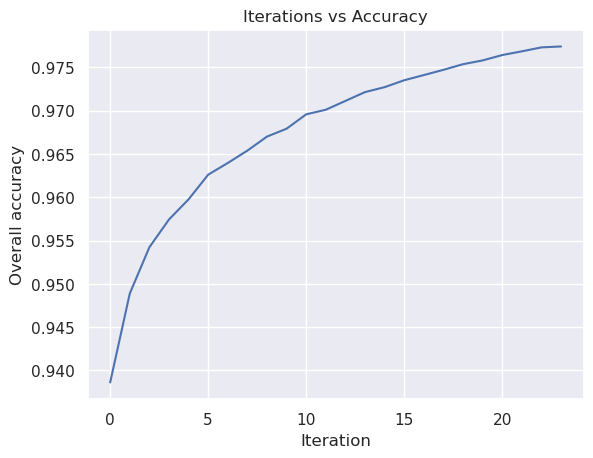

In [31]:
plt.plot(AccList)

plt.xlabel("Iteration")
plt.ylabel("Overall accuracy")

plt.title("Iterations vs Accuracy")

plt.show()


## Output model

In [32]:
OUTS = f"""{datetime.now().strftime("%Y_%m_%d")}_Trained_radial_RF_Lille.joblib"""

joblib.dump(rf, f"""/home/sspiegel/CapstoneData/Paris/RF_models/{OUTS}""")

['/home/sspiegel/CapstoneData/Paris/RF_models/2025_11_12_Trained_radial_RF_Lille.joblib']